In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)
from syn_model import *
from filter_data import *


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
import plotly.figure_factory as ff
%matplotlib inline
import json

from scipy.stats import kstest

from sklearn.metrics import mean_squared_error
import math


In [3]:

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [4]:
from load_and_clean import *

#update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population, fast=True), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True, fast=True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population, fast=True), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True, fast=True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True, fast=True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True, fast=True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

These countries/region do not have population data:  {'Virgin Islands'}
These countries/region do not have population data:  {'Eswatini', 'France-Martinique', 'Saint Kitts and Nevis', 'France-Saint Barthelemy', 'Canada-Alberta', 'China-Shanghai', 'Canada-Newfoundland and Labrador', 'France-Mayotte', 'Canada-Northwest Territories', 'Summer Olympics 2020', 'France-French Guiana', 'Saint Lucia', 'Burma', 'China-Hong Kong', 'Denmark-Faroe Islands', 'Australia-Victoria', 'China-Jiangxi', 'Cabo Verde', 'France-Guadeloupe', 'France-New Caledonia', 'Micronesia', 'China-Shanxi', 'Canada-New Brunswick', 'China-Inner Mongolia', 'Australia-Australian Capital Territory', 'Canada-Nunavut', 'Canada-Quebec', 'West Bank and Gaza', 'United Kingdom-Channel Islands', 'France-French Polynesia', 'France-St Martin', 'France-Reunion', 'Kyrgyzstan', 'Slovakia', 'Australia-Tasmania', 'United Kingdom-Saint Helena, Ascension and Tristan da Cunha', 'China-Hainan', "Cote d'Ivoire", 'Saint Vincent and the Grenadines

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:229: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:49: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap = df.columns & pop
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:55: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap2 = df2.columns &

In [5]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)


last date
Exceptions are []


In [6]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

# Testing our donorpool selection method

In [7]:
all_cases_data_pop_daily.columns

Index(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia',
       ...
       'York-South Carolina', 'York-Virginia', 'Young-Texas',
       'Yuba-California', 'Yukon-Koyukuk Census Area-Alaska', 'Yuma-Arizona',
       'Yuma-Colorado', 'Zapata-Texas', 'Zavala-Texas',
       'Ziebach-South Dakota'],
      dtype='object', length=3370)

In [8]:
import collections
import plotly.figure_factory as ff
from urllib.request import urlopen
import datetime as dt

donor_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]

donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in donor_states and names[0] != 'Unknown':
        donors.append(counties)


targets = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] == 'Vermont' and names[0] != 'Unknown':
        targets.append(counties)


In [9]:
print(targets)

['Addison-Vermont', 'Bennington-Vermont', 'Caledonia-Vermont', 'Chittenden-Vermont', 'Essex-Vermont', 'Franklin-Vermont', 'Grand Isle-Vermont', 'Lamoille-Vermont', 'Orange-Vermont', 'Orleans-Vermont', 'Rutland-Vermont', 'Washington-Vermont', 'Windham-Vermont', 'Windsor-Vermont']


In [37]:
print(len(donors))

146


## Compute MSE for our donor selection model; Backward Donor Elimination

In [10]:
def backward_donor_elimination(rscModel,include_self = True, metric=mean_squared_error, output = 'error_ratio'):
    '''
    Find the error ratio from removing each of the states within the donorpool

    @param
    metric: metric used to calculate ri values
    '''
    def syn_fit():
        temp_model = syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, hi_thresh, low_thresh, 
                            random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        temp_model.fit_model(force_positive=False)
        return temp_model

    out_dict = dict()
    #models = dict()

    #if include_self:
    #    out_dict[rscModel.state] = rscModel.find_ri(metric)

    for donor in rscModel.donors:
        donorPool = rscModel.donors.copy()
        donorPool.remove(donor)
        #only pre-intervention
        
        if output == 'error_ratio':
            hi_thresh, low_thresh = rscModel.low_thresh, int(rscModel.low_thresh*.8)
            temp_model = syn_fit()
            out_dict[donor] = temp_model.find_ri(metric)
            
        elif output == 'training_error':
            hi_thresh, low_thresh = rscModel.thresh, rscModel.low_thresh
            temp_model = syn_fit()
            out_dict[donor] = temp_model.train_err
            
        #models[donor] = temp_model

        '''
        all_donors = np.array(list(out_dict.keys()))
        values = np.array(list(out_dict.values()))
        max_value = max(values)
        new_donors = all_donors[(values < max_value)]
        new_values = values[(values < max_value)]

        new_donors, new_values = all_donors, values
        '''
    
    new_donors = np.array(list(out_dict.keys()))
    values = np.array(list(out_dict.values()))
    max_value = max(values)
    print('donors:', len(new_donors),'removed:',new_donors[values == max_value ])
    new_donors,values = new_donors[(values < max_value)], values[(values < max_value)]
    
    return new_donors


### eliminiate donors until the training error no longer decreases (break condition)

In [154]:
#df = df[df.columns[(df>100).any()]].copy()
import warnings
warnings.filterwarnings("ignore")

start_date = '2020-04-01'
low_thresh_date = '2020-06-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
#high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
#high_thresh = int(low_thresh/0.8)
high_thresh, low_thresh = low_thresh, int(low_thresh*.8)



plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []

i=1
for state in donors:# for state in ['Albany-New York']: #
    
    #otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
        
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
      
    rscModel1 = rscModel
    final_donors = rscModel1.donors
    print('\n\ntarget:', state)
    while len(final_donors)>3:
        #rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        #rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
        #train_err1 = rscModel.train_err
        new_donors = backward_donor_elimination(rscModel1, metric=mean_squared_error, output = 'training_error')
        
        '''
        print(new_donors)
        rscModel1 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=final_donors)
        rscModel1.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
        '''
        rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=list(new_donors))
        #temp_model=syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, high_thresh, low_thresh, 
        #                    random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')

        print('training error before:', rscModel1.train_err,'training error after:', rscModel2.train_err)
        if rscModel1.train_err <= rscModel2.train_err:
            break
        final_donors = new_donors
        rscModel1 = rscModel2
    #print(final_donors)    

        
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    
    test_MSE[1].append(rscModel1.testing_error())
    train_MSE[1].append(rscModel1.training_error())
    donor_size[1].append(rscModel1.donors)
    singvals[1].append(rscModel1.kSingularValues)
    target_counties.append(state)
    
    



target: Addison-Vermont
donors: 45 removed: ['Windham-Vermont']
training error before: 55.26545759065374 training error after: 77.54394640317798


target: Albany-New York
donors: 42 removed: ['Greene-New York']
training error before: 77.78259297216565 training error after: 110.666406877277


target: Allegany-New York
donors: 40 removed: ['Otsego-New York']
training error before: 34.48591726993754 training error after: 43.13875314973646


target: Androscoggin-Maine
donors: 40 removed: ['Hamilton-New York']
training error before: 6.564670274187354 training error after: 10.253834082542989


target: Aroostook-Maine
donors: 9 removed: ['Washington-Maine']
training error before: 1.1561069361765621 training error after: 1.3155654675927901


target: Atlantic-New Jersey
donors: 39 removed: ['Bristol-Rhode Island']
training error before: 619.2853448449508 training error after: 395.06072959337587
donors: 38 removed: ['Gloucester-New Jersey']
training error before: 395.06072959337587 training er



target: Grand Isle-Vermont
donors: 31 removed: ['Tarrant-Texas']
training error before: 116.01425974646266 training error after: 131.88842858149033


target: Greene-New York
donors: 45 removed: ['Warren-New York']
training error before: 489.4986513957391 training error after: 617.9805029004362


target: Hamilton-New York
donors: 47 removed: ['Dallas-Texas']
training error before: 209.12213272229025 training error after: 228.01672189025902


target: Hampden-Massachusetts
donors: 37 removed: ['Fairfield-Connecticut']
training error before: 232.01938082175624 training error after: 265.7562708074922


target: Hampshire-Massachusetts
donors: 45 removed: ['Atlantic-New Jersey']
training error before: 180.88773973080384 training error after: 379.1317532197051


target: Hancock-Maine
donors: 6 removed: ['Dallas-Texas']
training error before: 1.3338035759463889 training error after: 6.581104727228626


target: Hartford-Connecticut
donors: 39 removed: ['New Haven-Connecticut']
training error b



target: Otsego-New York
donors: 45 removed: ['Kennebec-Maine']
training error before: 14.487356728478257 training error after: 19.569021953586848


target: Oxford-Maine
donors: 16 removed: ['Mobile-Alabama']
training error before: 2.1933357572029726 training error after: 2.3414034443333627


target: Passaic-New Jersey
donors: 20 removed: ['Sullivan-New York']
training error before: 3196.3396850624986 training error after: 3659.399216646108


target: Penobscot-Maine
donors: 32 removed: ['Mobile-Alabama']
training error before: 55.07436577031182 training error after: 58.03519825435275


target: Piscataquis-Maine
donors: 8 removed: ['Coos-New Hampshire']
training error before: 5.632413441412261 training error after: 9.704473591585488


target: Plymouth-Massachusetts
donors: 34 removed: ['Putnam-New York']
training error before: 1589.8942825205518 training error after: 369.9003464674189
donors: 33 removed: ['Bristol-Massachusetts']
training error before: 369.9003464674189 training error 

training error before: 27.392062548929218 training error after: 32.50005560895456


target: Yates-New York
donors: 38 removed: ['Kennebec-Maine']
training error before: 33.745284836521265 training error after: 46.49830892582494


target: York-Maine
donors: 46 removed: ['Hamilton-New York']
training error before: 5.331105549282686 training error after: 6.848566232974117


In [155]:
print('test MSE:\n', test_MSE)
print('__________________\n__________________')
print('training MSE:\n', train_MSE)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size[0][i]) for i in range(len(donor_size[0]))], [len(donor_size[1][i]) for i in range(len(donor_size[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals)
print('__________________\n__________________')
print('targets:', target_counties)


print('test MSE standard:', np.mean(test_MSE[0]),'test MSE, our method:',np.mean(test_MSE[1]))

print('train MSE standard:',np.mean(train_MSE[0]),'train MSE, our method:', np.mean(train_MSE[1]))

print('error ratio standard:',np.mean([test_MSE[0][i]/train_MSE[0][i] for i in range(len(train_MSE[0]))]))
print('error ratio, our method:',np.mean([test_MSE[1][i]/train_MSE[1][i] for i in range(len(train_MSE[1]))]))


test MSE:
 [[13.566563883581441, 263.28374011684974, 230.73492748177364, 4585.4930860865925, 1.1076415789087704, 507.90912703535076, 143.91066647273507, 26.20158844808983, 885.5708201619096, 1255.8269538721863, 109.17188426778796, 2621.447900264533, 2531.9113981703385, 220.70964714087532, 1278.696230005233, 70.94194708439119, 244.1088689293223, 2366.5665139213406, 36.15832146698239, 37.46693142317683, 63.04714592828166, 46.286207699712236, 7.386486190223825, 70.6135685930531, 42.753627972600825, 80.64471376345814, 82.09839472326922, 5167.787107947476, 37.279783187555125, 18.683609219637905, 690.245821852601, 10631.787376225951, 8.384715109450088, 230.50770883709953, 4747.480858396573, 89.13603302191618, 3905.739950071289, 2424.669874064338, 792.0010776467107, 46.45007084398518, 639.1188693295347, 83.13178076993191, 1697.8702760457388, 48.89977862406683, 41.21388492721196, 6062.428142545908, 6616.649256593516, 112.07080080159892, 6.339431388295554, 75.18046265757349, 1935.331699992658, 

### eliminiate donors until the error ratio no longer decreases (break condition)

In [11]:
#df = df[df.columns[(df>100).any()]].copy()
import warnings
warnings.filterwarnings("ignore")

start_date = '2020-04-01'
low_thresh_date = '2020-06-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []
target_donors = {}

i=1

hi_thresh, lo_thresh = low_thresh, int(low_thresh*.8)
for state in donors:# for state in ['Albany-New York']: #
#otherStates = donors.copy()
    try:
        # TODO: should I replaced low_thresh with 0?
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
        
    rscModel =syn_model(state, singVals, [df], hi_thresh, lo_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue

      
    #hi_thresh, lo_thresh = rscModel.low_thresh, int(rscModel.low_thresh*.8)
    rscModel1 = rscModel
    final_donors = rscModel1.donors
    print('\n\ntarget:', state)
    while len(final_donors)>3:
        
        new_donors = backward_donor_elimination(rscModel1, metric=mean_squared_error)
        
        '''
        print(new_donors)
        rscModel1 =syn_model(state, singVals, [df], hi_thresh, lo_thresh, otherStates=final_donors)
        rscModel1.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
        '''
        rscModel2 =syn_model(state, singVals, [df], hi_thresh, lo_thresh, otherStates=list(new_donors))
        #temp_model=syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, hi_thresh, low_thresh, 
        #                    random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')

        print('error ratio before:', rscModel1.find_ri(mean_squared_error),'error ratio after:',  rscModel2.find_ri(mean_squared_error))
        if rscModel1.find_ri(mean_squared_error) <= rscModel2.find_ri(mean_squared_error):
            break
        final_donors = new_donors
        rscModel1 = rscModel2
    #print(final_donors)    
    
    target_donors[state] = final_donors
        
        
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    
    test_MSE[1].append(rscModel1.testing_error())
    train_MSE[1].append(rscModel1.training_error())
    donor_size[1].append(rscModel1.donors)
    singvals[1].append(rscModel1.kSingularValues)
    target_counties.append(state)
    
    



target: Addison-Vermont
donors: 46 removed: ['Dukes-Massachusetts']
error ratio before: 0.2726672981016488 error ratio after: 0.524597264386094


target: Albany-New York
donors: 41 removed: ['Washington-New York']
error ratio before: 6.4580023147863095 error ratio after: 2.9918470266274166
donors: 40 removed: ['Bristol-Rhode Island']
error ratio before: 2.9918470266274166 error ratio after: 9.479664956103976


target: Allegany-New York
donors: 36 removed: ['Essex-New York']
error ratio before: 9.688281287705417 error ratio after: 6.493584692524334
donors: 35 removed: ['Lamoille-Vermont']
error ratio before: 6.493584692524334 error ratio after: 6.519516850013462


target: Androscoggin-Maine
donors: 43 removed: ['Merrimack-New Hampshire']
error ratio before: 846.5130347192182 error ratio after: 809.9356123048951
donors: 42 removed: ['Steuben-New York']
error ratio before: 809.9356123048951 error ratio after: 820.929434663809


target: Aroostook-Maine
donors: 8 removed: ['Jefferson-Alab

donors: 46 removed: ['Tompkins-New York']
error ratio before: 6.564154393104451 error ratio after: 9.283100121639908


target: Dukes-Massachusetts
donors: 43 removed: ['Rensselaer-New York']
error ratio before: 3.754492020774319 error ratio after: 2.267938283995702
donors: 42 removed: ['Broome-New York']
error ratio before: 2.267938283995702 error ratio after: 0.5422957292321615
donors: 41 removed: ['Bennington-Vermont']
error ratio before: 0.5422957292321615 error ratio after: 0.7086428451125257


target: Dutchess-New York
donors: 40 removed: ['Sullivan-New York']
error ratio before: 1.874603294005277 error ratio after: 1.5669613131170688
donors: 39 removed: ['Monmouth-New Jersey']
error ratio before: 1.5669613131170688 error ratio after: 1.396475719896198
donors: 38 removed: ['Bergen-New Jersey']
error ratio before: 1.396475719896198 error ratio after: 2.095862837976445


target: Erie-New York
donors: 40 removed: ['Columbia-New York']
error ratio before: 12.129406135234005 error rati



target: Lincoln-Maine
donors: 25 removed: ['Dallas-Texas']
error ratio before: 4.373899366044292 error ratio after: 2.3135901910226924
donors: 24 removed: ['Harris-Texas']
error ratio before: 2.3135901910226924 error ratio after: 2.1658079628709115
donors: 23 removed: ['Caledonia-Vermont']
error ratio before: 2.1658079628709115 error ratio after: 3.130382629726711


target: Litchfield-Connecticut
donors: 41 removed: ['Warren-New Jersey']
error ratio before: 6.851045060131377 error ratio after: 8.955549662109224


target: Livingston-New York
donors: 47 removed: ['Schoharie-New York']
error ratio before: 3.4577105453122288 error ratio after: 1.9967633843967112
donors: 46 removed: ['Bennington-Vermont']
error ratio before: 1.9967633843967112 error ratio after: 2.560538099988188


target: Madison-New York
donors: 42 removed: ['Columbia-New York']
error ratio before: 4.356767668562883 error ratio after: 4.569569096946095


target: Mercer-New Jersey
donors: 37 removed: ['Sullivan-New York'

donors: 34 removed: ['Mercer-New Jersey']
error ratio before: 4.073789592877521 error ratio after: 4.301001137977289


target: Putnam-New York
donors: 41 removed: ['Fairfield-Connecticut']
error ratio before: 1.832732648399569 error ratio after: 1.6233000251826644
donors: 40 removed: ['Plymouth-Massachusetts']
error ratio before: 1.6233000251826644 error ratio after: 1.928580301641475


target: Rensselaer-New York
donors: 49 removed: ['Madison-New York']
error ratio before: 8.511728578725611 error ratio after: 11.085467970204046


target: Rockingham-New Hampshire
donors: 40 removed: ['Madison-New York']
error ratio before: 0.5433470609121321 error ratio after: 0.9994432691956103


target: Rockland-New York
donors: 15 removed: ['Suffolk-New York']
error ratio before: 2.8541414659751743 error ratio after: 1.9109054121569393
donors: 14 removed: ['Orange-New York']
error ratio before: 1.9109054121569393 error ratio after: 1.2042120199177844
donors: 13 removed: ['Harris-Texas']
error ratio 

donors: 7 removed: ['Madison-Alabama']
error ratio before: 0.10438171416374124 error ratio after: 0.916670684481578


target: Washington-New York
donors: 40 removed: ['Bristol-Rhode Island']
error ratio before: 1.8653648408011358 error ratio after: 0.16298984522878507
donors: 39 removed: ['Hampshire-Massachusetts']
error ratio before: 0.16298984522878507 error ratio after: 0.3120776669591073


target: Washington-Rhode Island
donors: 41 removed: ['Madison-New York']
error ratio before: 1.8141083591823866 error ratio after: 0.6060294688333845
donors: 40 removed: ['Franklin-Vermont']
error ratio before: 0.6060294688333845 error ratio after: 0.8792384534588549


target: Washington-Vermont
donors: 30 removed: ['Essex-Vermont']
error ratio before: 5.481494012032447 error ratio after: 3.8384016266556684
donors: 29 removed: ['Franklin-New York']
error ratio before: 3.8384016266556684 error ratio after: 3.444917765434611
donors: 28 removed: ['Lincoln-Maine']
error ratio before: 3.44491776543461

In [12]:
print('test MSE:\n', test_MSE)
print('__________________\n__________________')
print('training MSE:\n', train_MSE)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size[0][i]) for i in range(len(donor_size[0]))], [len(donor_size[1][i]) for i in range(len(donor_size[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals)
print('__________________\n__________________')
print('targets:', target_counties)


print('test MSE standard:', np.mean(test_MSE[0]),'test MSE, our method:',np.mean(test_MSE[1]))

print('train MSE standard:',np.mean(train_MSE[0]),'train MSE, our method:', np.mean(train_MSE[1]))

print('error ratio standard:',np.mean([test_MSE[0][i]/train_MSE[0][i] for i in range(len(train_MSE[0]))]))
print('error ratio, our method:',np.mean([test_MSE[1][i]/train_MSE[1][i] for i in range(len(train_MSE[1]))]))


test MSE:
 [[11.295137873003808, 248.83578468639845, 446.63371596601047, 5172.184241470119, 3.7654109526232404, 1433.595186427894, 212.4839156086804, 63.52091437951373, 287.05578074771915, 408.8528221345032, 263.54097916719144, 419.6676652948925, 5664.376455093644, 965.4030817242143, 188.04512428261944, 24.386375901013338, 34.2411010965323, 714.4238408543983, 104.29850306933658, 50.981511562757845, 129.51965263648077, 218.1625027688364, 69.56425379610303, 242.7876850966317, 43.09800771875873, 94.1159916340627, 171.24141575518024, 2206.7822646997683, 24.789822281909466, 14.701385101568002, 413.76404434871847, 4596.3083487595695, 141.91480304768388, 268.01507589734143, 1192.6851498580515, 430.22986362127307, 569.127013982321, 2327.5814233064216, 233.5891650339477, 354.49020301636915, 188.52605113686454, 8.941906776487295, 704.3547157829779, 1.7997886875765727, 65.65370298169061, 5447.96585154064, 35.364885079167934, 43.37126230526136, 22.394999763961295, 752.8020834166736, 279.0912016272

In [13]:
target_donors

{'Addison-Vermont': ['Allegany-New York',
  'Belknap-New Hampshire',
  'Bennington-Vermont',
  'Carroll-New Hampshire',
  'Cattaraugus-New York',
  'Cayuga-New York',
  'Chemung-New York',
  'Clinton-New York',
  'Delaware-New York',
  'Dukes-Massachusetts',
  'Essex-New York',
  'Franklin-Maine',
  'Franklin-Vermont',
  'Grand Isle-Vermont',
  'Hamilton-New York',
  'Herkimer-New York',
  'Kennebec-Maine',
  'Lamoille-Vermont',
  'Livingston-New York',
  'Merrimack-New Hampshire',
  'Montgomery-New York',
  'Nantucket-Massachusetts',
  'Ontario-New York',
  'Oswego-New York',
  'Otsego-New York',
  'Rutland-Vermont',
  'Saratoga-New York',
  'Schoharie-New York',
  'Seneca-New York',
  'St. Lawrence-New York',
  'Steuben-New York',
  'Strafford-New Hampshire',
  'Tompkins-New York',
  'Waldo-Maine',
  'Wayne-New York',
  'Windham-Vermont',
  'Windsor-Vermont',
  'Wyoming-New York',
  'Yates-New York',
  'York-Maine',
  'Jefferson-Alabama',
  'Madison-Alabama',
  'Mobile-Alabama',
  'H

## histogram based outlier detection


In [19]:
def permutation_non_ratio(rscModel, train_err = True, include_self = False):
    out_dict = dict()
    #models = dict()

    if include_self:
        if train_err:
            out_dict[rscModel.state] = rscModel.train_err
        else: 
            out_dict[donor] = temp_model.test_err 

    for donor in rscModel.donors:
        donorPool = rscModel.donors.copy()
        donorPool.remove(donor)
        temp_model = syn_model(donor, rscModel.kSingularValues, rscModel.dfs, rscModel.thresh, rscModel.low_thresh, 
                            random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        temp_model.fit_model(force_positive=False)
        if train_err:
            out_dict[donor] = temp_model.train_err
        else: 
            out_dict[donor] = temp_model.test_err 
        #models[donor] = temp_model


    return out_dict


def get_pre_filter(state, singVals, high_thresh, low_thresh):
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                  df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                  > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        return
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
    # Adding outliers:
    for item in outliers:
        otherStates.append(item)
        
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        return
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        return 
    
    return rscModel#.testing_error(), rscModel.training_error(), rscModel.donors, rscModel.kSingularValues
    

### two-dimension HBO

--------------- 
 Addison-Vermont
9.858835459490196 16.51601675206047 0.07980971362355012 6.425137002069344


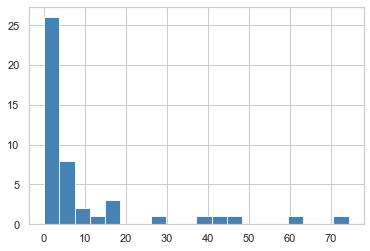

['Dukes-Massachusetts' 'Livingston-New York' 'Strafford-New Hampshire'
 'Jefferson-Alabama' 'Madison-Alabama' 'Harris-Texas' 'Dallas-Texas']
--------------- 
 Bennington-Vermont
9.582367216659803 15.77565439235586 0.08511948615177807 6.505674406924941


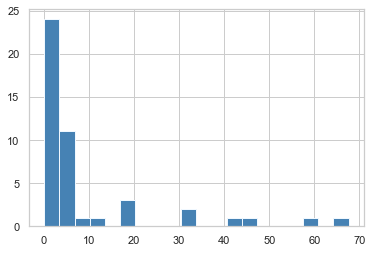

['Dukes-Massachusetts' 'Livingston-New York' 'Otsego-New York'
 'Strafford-New Hampshire' 'Jefferson-Alabama' 'Madison-Alabama']
--------------- 
 Caledonia-Vermont
21.714544254883407 23.480390957595024 1.6694261250604054 5.7737705810745075


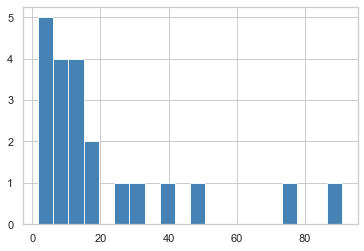

['Schuyler-New York' 'Madison-Alabama']
--------------- 
 Chittenden-Vermont
21.42711709129504 32.13072334613042 0.6273588821761948 11.112019148186048


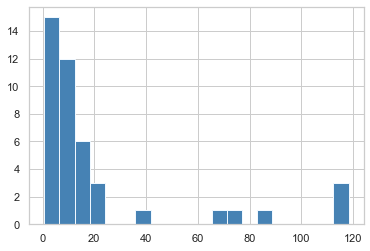

['Schoharie-New York' 'York-Maine' 'Harris-Texas' 'Dallas-Texas']
--------------- 
 Essex-Vermont
26.726607943016944 23.425139342960048 3.6968229483529127 8.303353315861326


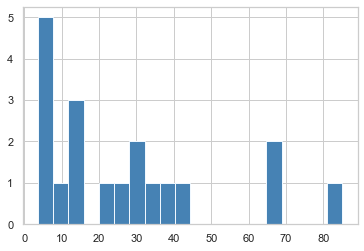

[]
--------------- 
 Franklin-Vermont
12.04606921995726 18.90958425425619 0.18369062709319015 7.908709262412565


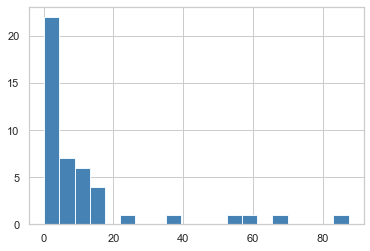

['Chittenden-Vermont' 'Dukes-Massachusetts' 'York-Maine'
 'Jefferson-Alabama' 'Madison-Alabama' 'Dallas-Texas']
--------------- 
 Grand Isle-Vermont
5.878126836573783 10.394360594918929 0.18078009875919798 4.746538783031715


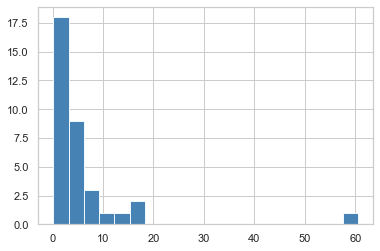

['Chautauqua-New York' 'Grafton-New Hampshire' 'Jefferson-Alabama'
 'Madison-Alabama' 'Harris-Texas']
--------------- 
 Lamoille-Vermont
8.698412160525791 15.34099342884862 0.416997819688845 4.994070869228045


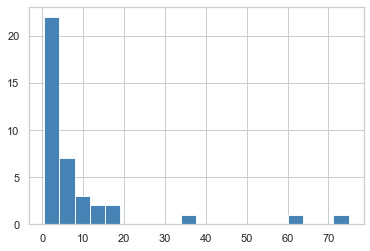

['Jefferson-Alabama' 'Madison-Alabama' 'Harris-Texas']
--------------- 
 Orange-Vermont
21.324335316783866 14.515505827411983 1.2076781775859735 3.4577847184685333


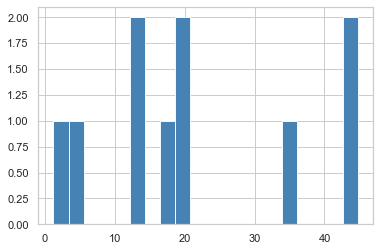

[]
--------------- 
 Orleans-Vermont
17.348766477918367 13.981248704860635 3.4551868182379115 3.4551868182379115


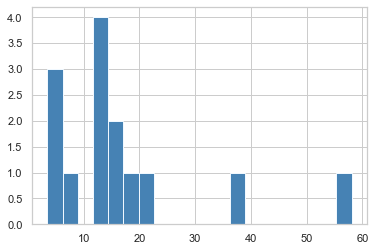

[]
--------------- 
 Rutland-Vermont
6.7315177224930975 11.562474192156765 0.13491293322653586 5.900867437512872


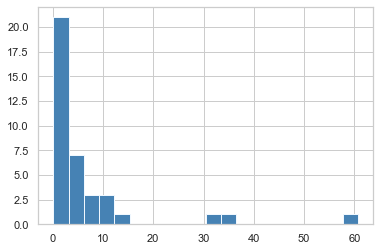

['Jefferson-Alabama' 'Madison-Alabama' 'Mobile-Alabama' 'Harris-Texas']
--------------- 
 Washington-Vermont
24.31225901600804 30.568673059463787 0.7559850363933683 10.892315236723025


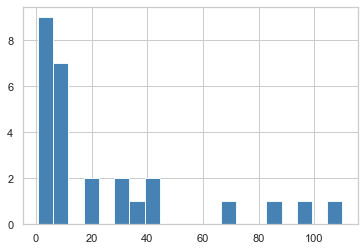

['Grafton-New Hampshire' 'Oxford-Maine' 'Jefferson-Alabama']
--------------- 
 Windham-Vermont
13.650605367138398 18.799753018793343 0.11182461897307501 9.10573686631352


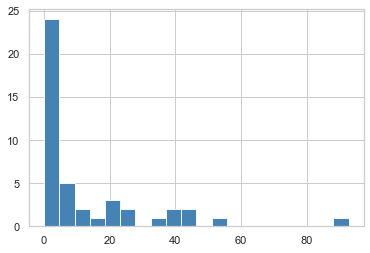

['Chenango-New York' 'Dukes-Massachusetts' 'York-Maine'
 'Jefferson-Alabama' 'Madison-Alabama' 'Dallas-Texas']
--------------- 
 Windsor-Vermont
7.531981306630607 12.813374424908313 0.07794265084349991 5.886278142022492


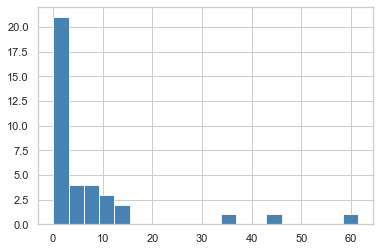

['Clinton-New York' 'Jefferson-Alabama' 'Madison-Alabama' 'Harris-Texas'
 'Dallas-Texas']


In [20]:
from pyod.models.hbos import HBOS

warnings.filterwarnings("ignore")

#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-06-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
#high_thresh = df_pop.shape[0]
high_thresh = int(low_thresh * 1.25)


plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE2 = [[],[],[]]
train_MSE2 = [[],[],[]]
donor_size2 = [[],[],[]]
singvals2 = [[],[],[]]
target_counties2 = []
TP = 0
FP = 0

outliers = set(['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas'])
i=1
for state in targets:
    # otherStates = donors.copy()
    orig_model = get_pre_filter(state, singVals, high_thresh, low_thresh)
    
    otherStates = list(target_donors[state])
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
    train_perm_dict = permutation_non_ratio(rscModel)
    train_values = np.array(list(perm_dict.values()))
    
    test_perm_dict = permutation_non_ratio(rscModel, train_err = False)
    test_values = np.array(list(perm_dict.values()))

    all_donors = np.array(list(perm_dict.keys()))
    values = np.array(list(perm_dict.values()))
    
    # show histogram
    print('--------------- \n',state)
    print(values.mean(), values.std(), min(values), max(values[values < max(values)*0.1]))
    fig, ax = plt.subplots(1,1, figsize = (6, 4))
    ax.hist(values, bins = 20, facecolor='steelblue', edgecolor='aliceblue')
    plt.show()
    
    ################################################
    ################################################
    # HBOS
    input_df =  pd.DataFrame([train_values,test_values]).transpose() # pd.DataFrame(values)
    hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
    hbos.fit(input_df)
    output = hbos.decision_function(input_df)
    res = hbos.predict(input_df)
    res = np.array(res, dtype = bool)
    print(all_donors[res])
    for item in all_donors[res]:
        if item in outliers:
            TP+=1
        else:
            FP+=1
    
    ################################################
    ################################################
    
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=list(all_donors[~res]))
    try:
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE2[0].append(rscModel.testing_error())
    train_MSE2[0].append(rscModel.training_error())
    donor_size2[0].append(rscModel.donors)
    singvals2[0].append(rscModel.kSingularValues)
    
    
    test_MSE2[1].append(rscModel2.testing_error())
    train_MSE2[1].append(rscModel2.training_error())
    donor_size2[1].append(rscModel2.donors)
    singvals2[1].append(rscModel2.kSingularValues)
    
    test_MSE2[2].append(orig_model.testing_error())
    train_MSE2[2].append(orig_model.training_error())
    donor_size2[2].append(orig_model.donors)
    singvals2[2].append(orig_model.kSingularValues)
    
    target_counties2.append(state)
    
    

In [21]:
print('test MSE:\n', test_MSE2)
print('__________________\n__________________')
print('training MSE:\n', train_MSE2)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size2[0][i]) for i in range(len(donor_size2[0]))], [len(donor_size2[1][i]) for i in range(len(donor_size2[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals2)
print('__________________\n__________________')
print('targets:', target_counties2)


print('test MSE orig:', np.mean(test_MSE2[2]),'test MSE, our method:',np.mean(test_MSE2[1]))
print('train MSE orig:',np.mean(train_MSE2[2]),'train MSE, our method:', np.mean(train_MSE2[1]))

print('error ratio orig:',np.mean([test_MSE2[2][i]/train_MSE2[2][i] for i in range(len(train_MSE2[2]))]))
print('error ratio, backward donor elim:',np.mean([test_MSE2[0][i]/train_MSE2[0][i] for i in range(len(train_MSE2[0]))]))
print('error ratio, our method:',np.mean([test_MSE2[1][i]/train_MSE2[1][i] for i in range(len(train_MSE2[1]))]))



test MSE:
 [[95.93538104051524, 280.4390643962301, 25.10079771976387, 1228.111863083009, 1070.6111713515663, 421.62493342285796, 661.3552232152343, 0.3435584928683061, 27.09805782674155, 86.99851879905516, 9.640409001524016, 4.561281953431446, 188.7174610561316, 18.703384376173496], [23.899689634934965, 272.03979794222397, 14.27525451836883, 1461.8109290982268, 1070.6111713515663, 16.54593229334493, 186.37470610270637, 0.0, 27.09805782674155, 86.99851879905516, 18.94161127899624, 83.81871725397504, 151.79126800587855, 14.515434422662894], [95.93538104051613, 280.4390643962297, 25.100797719763815, 1228.1118630830126, 1445.726914446392, 421.6249334228558, 347.8296312422248, 0.34355849286831325, 12.66186945814137, 86.99851879905509, 6.338751475210296, 18.8927916712512, 169.09399613528007, 18.195994952441634]]
__________________
__________________
training MSE:
 [[32.15332597431976, 52.68732471501626, 6.87344768155814, 23.74770644786093, 197.89840875752475, 216.3196236687488, 54.7766422240

In [26]:
recall = TP/(6*len(targets))
precision = TP/(TP+FP)
print(precision, recall)

0.5882352941176471 0.35714285714285715


### one dimension HBO

--------------- 
 Addison-Vermont
9.858835459490196 16.51601675206047 0.07980971362355012 6.425137002069344


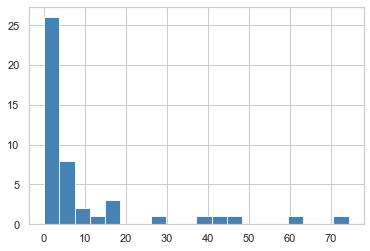

['Dukes-Massachusetts' 'Livingston-New York' 'Strafford-New Hampshire'
 'Jefferson-Alabama' 'Madison-Alabama' 'Harris-Texas' 'Dallas-Texas']
--------------- 
 Bennington-Vermont
9.582367216659803 15.77565439235586 0.08511948615177807 6.505674406924941


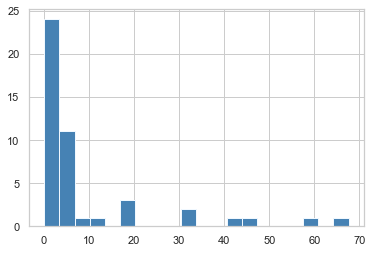

['Dukes-Massachusetts' 'Livingston-New York' 'Otsego-New York'
 'Strafford-New Hampshire' 'Jefferson-Alabama' 'Madison-Alabama']
--------------- 
 Caledonia-Vermont
21.714544254883407 23.480390957595024 1.6694261250604054 5.7737705810745075


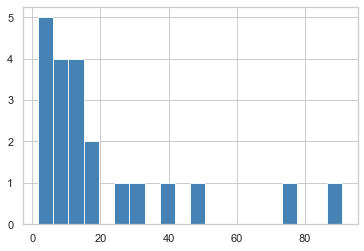

['Schuyler-New York' 'Madison-Alabama']
--------------- 
 Chittenden-Vermont
21.42711709129504 32.13072334613042 0.6273588821761948 11.112019148186048


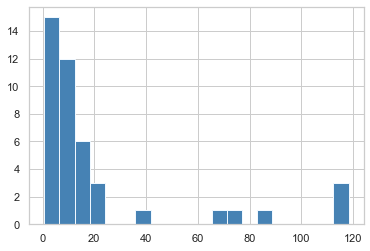

['Schoharie-New York' 'York-Maine' 'Harris-Texas' 'Dallas-Texas']
--------------- 
 Essex-Vermont
26.726607943016944 23.425139342960048 3.6968229483529127 8.303353315861326


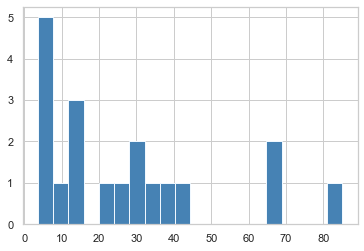

[]
--------------- 
 Franklin-Vermont
12.04606921995726 18.90958425425619 0.18369062709319015 7.908709262412565


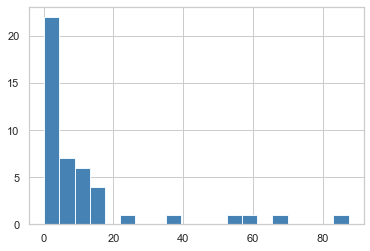

['Chittenden-Vermont' 'Dukes-Massachusetts' 'York-Maine'
 'Jefferson-Alabama' 'Madison-Alabama' 'Dallas-Texas']
--------------- 
 Grand Isle-Vermont
5.878126836573783 10.394360594918929 0.18078009875919798 4.746538783031715


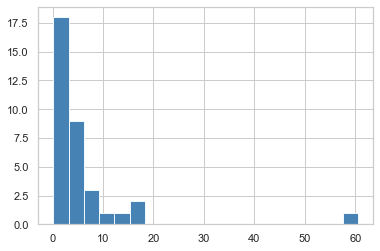

['Chautauqua-New York' 'Grafton-New Hampshire' 'Jefferson-Alabama'
 'Madison-Alabama' 'Harris-Texas']
--------------- 
 Lamoille-Vermont
8.698412160525791 15.34099342884862 0.416997819688845 4.994070869228045


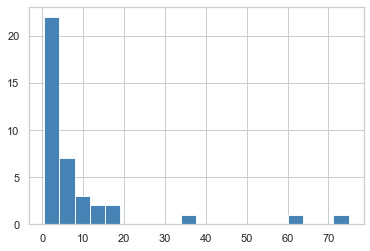

['Jefferson-Alabama' 'Madison-Alabama' 'Harris-Texas']
--------------- 
 Orange-Vermont
21.324335316783866 14.515505827411983 1.2076781775859735 3.4577847184685333


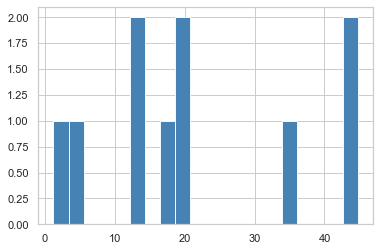

[]
--------------- 
 Orleans-Vermont
17.348766477918367 13.981248704860635 3.4551868182379115 3.4551868182379115


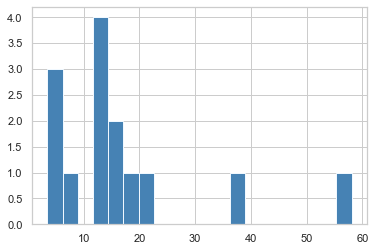

[]
--------------- 
 Rutland-Vermont
6.7315177224930975 11.562474192156765 0.13491293322653586 5.900867437512872


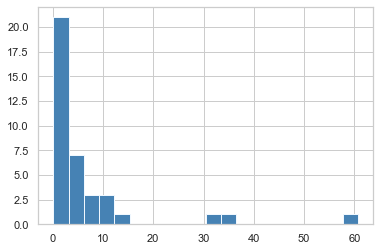

['Jefferson-Alabama' 'Madison-Alabama' 'Mobile-Alabama' 'Harris-Texas']
--------------- 
 Washington-Vermont
24.31225901600804 30.568673059463787 0.7559850363933683 10.892315236723025


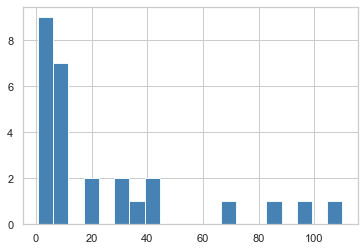

['Grafton-New Hampshire' 'Oxford-Maine' 'Jefferson-Alabama']
--------------- 
 Windham-Vermont
13.650605367138398 18.799753018793343 0.11182461897307501 9.10573686631352


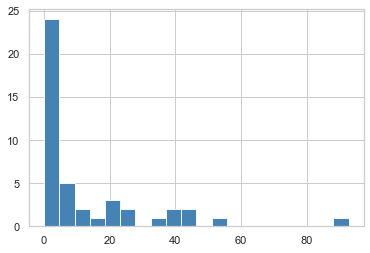

['Chenango-New York' 'Dukes-Massachusetts' 'York-Maine'
 'Jefferson-Alabama' 'Madison-Alabama' 'Dallas-Texas']
--------------- 
 Windsor-Vermont
7.531981306630607 12.813374424908313 0.07794265084349991 5.886278142022492


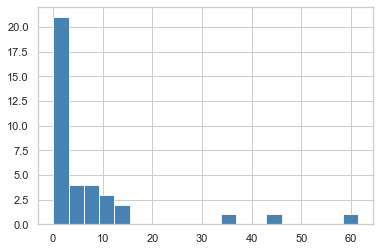

['Clinton-New York' 'Jefferson-Alabama' 'Madison-Alabama' 'Harris-Texas'
 'Dallas-Texas']


In [35]:
from pyod.models.hbos import HBOS

warnings.filterwarnings("ignore")

#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-06-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
#high_thresh = df_pop.shape[0]
high_thresh = int(low_thresh * 1.25)


plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE2 = [[],[],[]]
train_MSE2 = [[],[],[]]
donor_size2 = [[],[],[]]
singvals2 = [[],[],[]]
target_counties2 = []
TP = 0
FP = 0

outliers = set(['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas'])
i=1
for state in targets:
    # otherStates = donors.copy()
    orig_model = get_pre_filter(state, singVals, high_thresh, low_thresh)
    
    otherStates = list(target_donors[state])
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
    train_perm_dict = permutation_non_ratio(rscModel)
    train_values = np.array(list(perm_dict.values()))
    
    test_perm_dict = permutation_non_ratio(rscModel, train_err = False)
    test_values = np.array(list(perm_dict.values()))

    all_donors = np.array(list(perm_dict.keys()))
    values = np.array(list(perm_dict.values()))
    
    # show histogram
    print('--------------- \n',state)
    print(values.mean(), values.std(), min(values), max(values[values < max(values)*0.1]))
    fig, ax = plt.subplots(1,1, figsize = (6, 4))
    ax.hist(values, bins = 20, facecolor='steelblue', edgecolor='aliceblue')
    plt.show()
    
    ################################################
    ################################################
    # HBOS
    input_df =  pd.DataFrame(values)
    hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
    hbos.fit(input_df)
    output = hbos.decision_function(input_df)
    res = hbos.predict(input_df)
    res = np.array(res, dtype = bool)
    print(all_donors[res])
    for item in all_donors[res]:
        if item in outliers:
            TP+=1
        else:
            FP+=1
    
    ################################################
    ################################################
    
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=list(all_donors[~res]))
    try:
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE2[0].append(rscModel.testing_error())
    train_MSE2[0].append(rscModel.training_error())
    donor_size2[0].append(rscModel.donors)
    singvals2[0].append(rscModel.kSingularValues)
    
    
    test_MSE2[1].append(rscModel2.testing_error())
    train_MSE2[1].append(rscModel2.training_error())
    donor_size2[1].append(rscModel2.donors)
    singvals2[1].append(rscModel2.kSingularValues)
    
    test_MSE2[2].append(orig_model.testing_error())
    train_MSE2[2].append(orig_model.training_error())
    donor_size2[2].append(orig_model.donors)
    singvals2[2].append(orig_model.kSingularValues)
    
    target_counties2.append(state)
    
    

In [36]:
print('test MSE:\n', test_MSE2)
print('__________________\n__________________')
print('training MSE:\n', train_MSE2)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size2[0][i]) for i in range(len(donor_size2[0]))], [len(donor_size2[1][i]) for i in range(len(donor_size2[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals2)
print('__________________\n__________________')
print('targets:', target_counties2)


print('test MSE orig:', np.mean(test_MSE2[2]),'test MSE, our method:',np.mean(test_MSE2[1]))
print('train MSE orig:',np.mean(train_MSE2[2]),'train MSE, our method:', np.mean(train_MSE2[1]))

print('error ratio orig:',np.mean([test_MSE2[2][i]/train_MSE2[2][i] for i in range(len(train_MSE2[2]))]))
print('error ratio, backward donor elim:',np.mean([test_MSE2[0][i]/train_MSE2[0][i] for i in range(len(train_MSE2[0]))]))
print('error ratio, our method:',np.mean([test_MSE2[1][i]/train_MSE2[1][i] for i in range(len(train_MSE2[1]))]))



test MSE:
 [[95.93538104051524, 280.4390643962301, 25.10079771976387, 1228.111863083009, 1070.6111713515663, 421.62493342285796, 661.3552232152343, 0.3435584928683061, 27.09805782674155, 86.99851879905516, 9.640409001524016, 4.561281953431446, 188.7174610561316, 18.703384376173496], [23.899689634934965, 272.03979794222397, 14.27525451836883, 1461.8109290982268, 1070.6111713515663, 16.54593229334493, 186.37470610270637, 0.0, 27.09805782674155, 86.99851879905516, 18.94161127899624, 83.81871725397504, 151.79126800587855, 14.515434422662894], [95.93538104051613, 280.4390643962297, 25.100797719763815, 1228.1118630830126, 1445.726914446392, 421.6249334228558, 347.8296312422248, 0.34355849286831325, 12.66186945814137, 86.99851879905509, 6.338751475210296, 18.8927916712512, 169.09399613528007, 18.195994952441634]]
__________________
__________________
training MSE:
 [[32.15332597431976, 52.68732471501626, 6.87344768155814, 23.74770644786093, 197.89840875752475, 216.3196236687488, 54.7766422240

## our donor selection model; Permutation Distribution

In [33]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-06-01'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

#high_thresh = df_pop.shape[0]
high_thresh = int(low_thresh * 1.25)



plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE2 = [[],[],[]]
train_MSE2 = [[],[],[]]
donor_size2 = [[],[],[]]
singvals2 = [[],[],[]]
target_counties2 = []

i=1
for state in targets:
    orig_model = get_pre_filter(state, singVals, high_thresh, low_thresh)

    otherStates = list(target_donors[state])
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel2.fit_model(filter_donor = True, filter_method = 'iqr', singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE2[0].append(rscModel.testing_error())
    train_MSE2[0].append(rscModel.training_error())
    donor_size2[0].append(rscModel.donors)
    singvals2[0].append(rscModel.kSingularValues)
    
    test_MSE2[1].append(rscModel2.testing_error())
    train_MSE2[1].append(rscModel2.training_error())
    donor_size2[1].append(rscModel2.donors)
    singvals2[1].append(rscModel2.kSingularValues)
    
    test_MSE2[2].append(orig_model.testing_error())
    train_MSE2[2].append(orig_model.training_error())
    donor_size2[2].append(orig_model.donors)
    singvals2[2].append(orig_model.kSingularValues)
    
    target_counties2.append(state)
    
    

In [34]:
'''
print('Using combine donor filtering:\n__________________')
print('test MSE:\n', test_MSE_combine)
print('__________________\n__________________')
print('training MSE:\n', train_MSE_combine)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size_combine[0][i]) for i in range(len(donor_size_combine[0]))], [len(donor_size_combine[1][i]) for i in range(len(donor_size_combine[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals_combine)
print('__________________\n__________________')
print('targets:', target_counties_combine)


print('test MSE standard:', np.mean(test_MSE_combine[0]),'test MSE, our method:',np.mean(test_MSE_combine[1]))

print('train MSE standard:',np.mean(train_MSE_combine[0]),'train MSE, our method:', np.mean(train_MSE_combine[1]))

print('error ratio standard:',np.mean([test_MSE_combine[0][i]/train_MSE_combine[0][i] for i in range(len(train_MSE_combine[0]))]))
print('error ratio, our method:',np.mean([test_MSE_combine[1][i]/train_MSE_combine[1][i] for i in range(len(train_MSE_combine[1]))]))

'''

print('test MSE:\n', test_MSE2)
print('__________________\n__________________')
print('training MSE:\n', train_MSE2)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size2[0][i]) for i in range(len(donor_size2[0]))], [len(donor_size2[1][i]) for i in range(len(donor_size2[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals2)
print('__________________\n__________________')
print('targets:', target_counties2)


print('test MSE orig:', np.mean(test_MSE2[2]),'test MSE, our method:',np.mean(test_MSE2[1]))
print('train MSE orig:',np.mean(train_MSE2[2]),'train MSE, our method:', np.mean(train_MSE2[1]))

print('error ratio orig:',np.mean([test_MSE2[2][i]/train_MSE2[2][i] for i in range(len(train_MSE2[2]))]))
print('error ratio, backward donor elim:',np.mean([test_MSE2[0][i]/train_MSE2[0][i] for i in range(len(train_MSE2[0]))]))
print('error ratio, our method:',np.mean([test_MSE2[1][i]/train_MSE2[1][i] for i in range(len(train_MSE2[1]))]))



test MSE:
 [[95.93538104051524, 280.4390643962301, 25.10079771976387, 1228.111863083009, 1070.6111713515663, 421.62493342285796, 661.3552232152343, 0.3435584928683061, 27.09805782674155, 86.99851879905516, 9.640409001524016, 4.561281953431446, 188.7174610561316, 18.703384376173496], [21.879695032706113, 84.80120229971827, 15.987599266846486, 1926.9645839372936, 38.33692927504238, 63.42844195899515, 207.13554346160672, 0.0007944729627492552, 26.565137156328024, 85.44124626089045, 18.893285962191268, 52.44513214014302, 17.170087689118034, 42.790206558819136], [95.93538104051613, 280.4390643962297, 25.100797719763815, 1228.1118630830126, 1445.726914446392, 421.6249334228558, 347.8296312422248, 0.34355849286831325, 12.66186945814137, 86.99851879905509, 6.338751475210296, 18.8927916712512, 169.09399613528007, 18.195994952441634]]
__________________
__________________
training MSE:
 [[32.15332597431976, 52.68732471501626, 6.87344768155814, 23.74770644786093, 197.89840875752475, 216.319623668

# MCMC

### eliminiate donors until the training error no longer decreases (break condition)


In [23]:
def mcmc_donor_selection(state, singVals, df,high_thresh, low_thresh, donorPool):

    h_thresh, l_thresh = low_thresh, int(low_thresh*.8)

    temp_model1 = syn_model(state, singVals, [df], h_thresh, l_thresh, otherStates=donorPool)
    temp_model1.fit_model(filter_donor = False,force_positive=False)

    final_donors = copy.deepcopy(donorPool)
    print('____________________________')
    print('donor pool selection for ', state)
    print('donor length before:', len(final_donors))
    while len(final_donors)>3:
        rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=donorPool)
        rscModel.fit_model(filter_donor = False, force_positive=False)
    
        perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')

        all_donors = np.array(list(perm_dict.keys()))
        values = np.array(list(perm_dict.values()))



        donorPool = rscModel.donors.copy()
        donor = random.choices(all_donors, weights=values)[0]
        print(donor)
        donorPool.remove(donor)
        temp_model2 = syn_model(state, singVals, [df], h_thresh, l_thresh, otherStates=donorPool)
        temp_model2.fit_model(filter_donor = False, force_positive=False)

        # TODO: change the break condition to training error of rscModel
        if temp_model1.find_ri(mean_squared_error) < temp_model2.find_ri(mean_squared_error):
            break

        final_donors = copy.deepcopy(donorPool)
        temp_model1 = temp_model2
   
    print('donor length after:', len(final_donors))
    return final_donors


In [24]:
#df = df[df.columns[(df>100).any()]].copy()
warnings.filterwarnings("ignore")
start_date = '2020-04-01'
low_thresh_date = '2020-05-24' #'2020-08-01'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []

i=1
for state in donors:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    new_donors = mcmc_donor_selection(state, singVals, df,high_thresh, low_thresh, otherStates)
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=new_donors)
    try:
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    
    test_MSE[1].append(rscModel2.testing_error())
    train_MSE[1].append(rscModel2.training_error())
    donor_size[1].append(rscModel2.donors)
    singvals[1].append(rscModel2.kSingularValues)
    target_counties.append(state)
    
    

____________________________
donor pool selection for  Addison-Vermont
donor length before: 47
Cayuga-New York
Clinton-New York
Madison-Alabama
Mobile-Alabama
Hamilton-New York
Dallas-Texas
donor length after: 42
____________________________
donor pool selection for  Albany-New York
donor length before: 41
Warren-New York
Madison-Alabama
donor length after: 40
____________________________
donor pool selection for  Allegany-New York
donor length before: 38
Harris-Texas
donor length after: 38
____________________________
donor pool selection for  Androscoggin-Maine
donor length before: 44
Jefferson-Alabama
donor length after: 44
____________________________
donor pool selection for  Aroostook-Maine
donor length before: 8
Coos-New Hampshire
donor length after: 8
____________________________
donor pool selection for  Atlantic-New Jersey
donor length before: 40
Madison-Alabama
Jefferson-Alabama
donor length after: 39
____________________________
donor pool selection for  Barnstable-Massachu

Mobile-Alabama
donor length after: 39
____________________________
donor pool selection for  Hampshire-Massachusetts
donor length before: 44
Jefferson-Alabama
Madison-Alabama
donor length after: 43
____________________________
donor pool selection for  Hancock-Maine
donor length before: 9
Aroostook-Maine
donor length after: 9
____________________________
donor pool selection for  Hartford-Connecticut
donor length before: 38
Madison-Alabama
Tarrant-Texas
Dallas-Texas
donor length after: 36
____________________________
donor pool selection for  Herkimer-New York
donor length before: 46
Addison-Vermont
Mobile-Alabama
donor length after: 45
____________________________
donor pool selection for  Hillsborough-New Hampshire
donor length before: 44
Madison-Alabama
donor length after: 44
____________________________
donor pool selection for  Hudson-New Jersey
donor length before: 25
Madison-Alabama
donor length after: 25
____________________________
donor pool selection for  Hunterdon-New Jerse

Bennington-Vermont
donor length after: 49
____________________________
donor pool selection for  Rockingham-New Hampshire
donor length before: 41
Madison-Alabama
Mobile-Alabama
Jefferson-Alabama
Oneida-New York
donor length after: 38
____________________________
donor pool selection for  Rockland-New York
donor length before: 15
Madison-Alabama
donor length after: 15
____________________________
donor pool selection for  Rutland-Vermont
donor length before: 38
Cheshire-New Hampshire
donor length after: 38
____________________________
donor pool selection for  Sagadahoc-Maine
donor length before: 36
Lamoille-Vermont
Nantucket-Massachusetts
Somerset-Maine
donor length after: 34
____________________________
donor pool selection for  Salem-New Jersey
donor length before: 41
Jefferson-Alabama
Madison-Alabama
donor length after: 40
____________________________
donor pool selection for  Saratoga-New York
donor length before: 46
Cayuga-New York
donor length after: 46
__________________________

In [25]:
print('test MSE:\n', test_MSE)
print('__________________\n__________________')
print('training MSE:\n', train_MSE)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size[0][i]) for i in range(len(donor_size[0]))], [len(donor_size[1][i]) for i in range(len(donor_size[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals)
print('__________________\n__________________')
print('targets:', target_counties)


print('test MSE standard:', np.mean(test_MSE[0]),'test MSE, our method:',np.mean(test_MSE[1]))

print('train MSE standard:',np.mean(train_MSE[0]),'train MSE, our method:', np.mean(train_MSE[1]))

print('error ratio standard:',np.mean([test_MSE[0][i]/train_MSE[0][i] for i in range(len(train_MSE[0]))]))
print('error ratio, our method:',np.mean([test_MSE[1][i]/train_MSE[1][i] for i in range(len(train_MSE[1]))]))


test MSE:
 [[23492.994935512386, 4263.235891615891, 12106.23198076807, 44806.96330091944, 11571.023610900875, 10274.844804876353, 13030.832663978765, 17620.160871912783, 11639.662125334587, 5831.40976159151, 7400.339604668522, 5908.147883599757, 46078.40399415643, 20896.714939991703, 6946.474470993049, 13198.120336002728, 3378.498706846899, 125398.17604497023, 3263.4969500729194, 14679.91182647431, 59105.35889157746, 45079.20210062803, 29208.27254491722, 11706.325713022077, 5054.6507024249995, 62786.82624848056, 13635.053019075991, 34904.17818208188, 55191.08526820394, 20469.429871600176, 4880.640134173684, 195810.4860381469, 12836.329211276274, 38733.758034076636, 19379.04921174407, 9495.770945891216, 9320.36368837345, 4974.010083430438, 23316.080249507428, 56754.36130938375, 27892.704144407242, 20945.134598330467, 20848.045855025666, 17148.152210244163, 24160.314183416973, 45272.02401274826, 56389.073812624985, 5098.241910016629, 6852.697058627907, 11195.28122277681, 11756.2806714082

### eliminiate donors until the training error no longer decreases (break condition)

In [ ]:
def mcmc_donor_selection(state, singVals, df,high_thresh, low_thresh, donorPool):

    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=donorPool)
    rscModel.fit_model(filter_donor = False, force_positive=False)

    final_donors = copy.deepcopy(donorPool)
    print('____________________________')
    print('donor pool selection for ', state)
    print('donor length before:', len(final_donors))
    while len(final_donors)>3:
        perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')

        all_donors = np.array(list(perm_dict.keys()))
        values = np.array(list(perm_dict.values()))

        donorPool = rscModel.donors.copy()
        donor = random.choices(all_donors, weights=values)[0]
        print(donor)
        donorPool.remove(donor)
       
        rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=donorPool)
        rscModel2.fit_model(filter_donor = False, force_positive=False)
           
        # TODO: change the break condition to training error of rscModel
        if rscModel.train_err <= rscModel2.train_err:
            break
        #train_err
        final_donors = copy.deepcopy(donorPool)
        rscModel = rscModel2
   
    print('donor length after:', len(final_donors))
    return final_donors


In [24]:
#df = df[df.columns[(df>100).any()]].copy()
warnings.filterwarnings("ignore")
start_date = '2020-04-01'
low_thresh_date = '2020-05-24' #'2020-08-01'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

test_MSE = [[],[]]
train_MSE = [[],[]]
donor_size = [[],[]]
singvals = [[],[]]
target_counties = []

i=1
for state in donors:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    new_donors = mcmc_donor_selection(state, singVals, df,high_thresh, low_thresh, otherStates)
    rscModel2 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=new_donors)
    try:
        rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        continue
        
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    
    
    test_MSE[1].append(rscModel2.testing_error())
    train_MSE[1].append(rscModel2.training_error())
    donor_size[1].append(rscModel2.donors)
    singvals[1].append(rscModel2.kSingularValues)
    target_counties.append(state)
    
    

____________________________
donor pool selection for  Addison-Vermont
donor length before: 47
Cayuga-New York
Clinton-New York
Madison-Alabama
Mobile-Alabama
Hamilton-New York
Dallas-Texas
donor length after: 42
____________________________
donor pool selection for  Albany-New York
donor length before: 41
Warren-New York
Madison-Alabama
donor length after: 40
____________________________
donor pool selection for  Allegany-New York
donor length before: 38
Harris-Texas
donor length after: 38
____________________________
donor pool selection for  Androscoggin-Maine
donor length before: 44
Jefferson-Alabama
donor length after: 44
____________________________
donor pool selection for  Aroostook-Maine
donor length before: 8
Coos-New Hampshire
donor length after: 8
____________________________
donor pool selection for  Atlantic-New Jersey
donor length before: 40
Madison-Alabama
Jefferson-Alabama
donor length after: 39
____________________________
donor pool selection for  Barnstable-Massachu

Mobile-Alabama
donor length after: 39
____________________________
donor pool selection for  Hampshire-Massachusetts
donor length before: 44
Jefferson-Alabama
Madison-Alabama
donor length after: 43
____________________________
donor pool selection for  Hancock-Maine
donor length before: 9
Aroostook-Maine
donor length after: 9
____________________________
donor pool selection for  Hartford-Connecticut
donor length before: 38
Madison-Alabama
Tarrant-Texas
Dallas-Texas
donor length after: 36
____________________________
donor pool selection for  Herkimer-New York
donor length before: 46
Addison-Vermont
Mobile-Alabama
donor length after: 45
____________________________
donor pool selection for  Hillsborough-New Hampshire
donor length before: 44
Madison-Alabama
donor length after: 44
____________________________
donor pool selection for  Hudson-New Jersey
donor length before: 25
Madison-Alabama
donor length after: 25
____________________________
donor pool selection for  Hunterdon-New Jerse

Bennington-Vermont
donor length after: 49
____________________________
donor pool selection for  Rockingham-New Hampshire
donor length before: 41
Madison-Alabama
Mobile-Alabama
Jefferson-Alabama
Oneida-New York
donor length after: 38
____________________________
donor pool selection for  Rockland-New York
donor length before: 15
Madison-Alabama
donor length after: 15
____________________________
donor pool selection for  Rutland-Vermont
donor length before: 38
Cheshire-New Hampshire
donor length after: 38
____________________________
donor pool selection for  Sagadahoc-Maine
donor length before: 36
Lamoille-Vermont
Nantucket-Massachusetts
Somerset-Maine
donor length after: 34
____________________________
donor pool selection for  Salem-New Jersey
donor length before: 41
Jefferson-Alabama
Madison-Alabama
donor length after: 40
____________________________
donor pool selection for  Saratoga-New York
donor length before: 46
Cayuga-New York
donor length after: 46
__________________________

In [25]:
print('test MSE:\n', test_MSE)
print('__________________\n__________________')
print('training MSE:\n', train_MSE)
print('__________________\n__________________')
#print('donors:\n', donor_size_iqr)
print('__________________\n__________________')
print('donor size:\n', [[len(donor_size[0][i]) for i in range(len(donor_size[0]))], [len(donor_size[1][i]) for i in range(len(donor_size[1]))]])
print('__________________\n__________________')
print('singvals:\n', singvals)
print('__________________\n__________________')
print('targets:', target_counties)


print('test MSE standard:', np.mean(test_MSE[0]),'test MSE, our method:',np.mean(test_MSE[1]))

print('train MSE standard:',np.mean(train_MSE[0]),'train MSE, our method:', np.mean(train_MSE[1]))

print('error ratio standard:',np.mean([test_MSE[0][i]/train_MSE[0][i] for i in range(len(train_MSE[0]))]))
print('error ratio, our method:',np.mean([test_MSE[1][i]/train_MSE[1][i] for i in range(len(train_MSE[1]))]))


test MSE:
 [[23492.994935512386, 4263.235891615891, 12106.23198076807, 44806.96330091944, 11571.023610900875, 10274.844804876353, 13030.832663978765, 17620.160871912783, 11639.662125334587, 5831.40976159151, 7400.339604668522, 5908.147883599757, 46078.40399415643, 20896.714939991703, 6946.474470993049, 13198.120336002728, 3378.498706846899, 125398.17604497023, 3263.4969500729194, 14679.91182647431, 59105.35889157746, 45079.20210062803, 29208.27254491722, 11706.325713022077, 5054.6507024249995, 62786.82624848056, 13635.053019075991, 34904.17818208188, 55191.08526820394, 20469.429871600176, 4880.640134173684, 195810.4860381469, 12836.329211276274, 38733.758034076636, 19379.04921174407, 9495.770945891216, 9320.36368837345, 4974.010083430438, 23316.080249507428, 56754.36130938375, 27892.704144407242, 20945.134598330467, 20848.045855025666, 17148.152210244163, 24160.314183416973, 45272.02401274826, 56389.073812624985, 5098.241910016629, 6852.697058627907, 11195.28122277681, 11756.2806714082

## A couple of examples for our donor selection model 

/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-package

/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-package

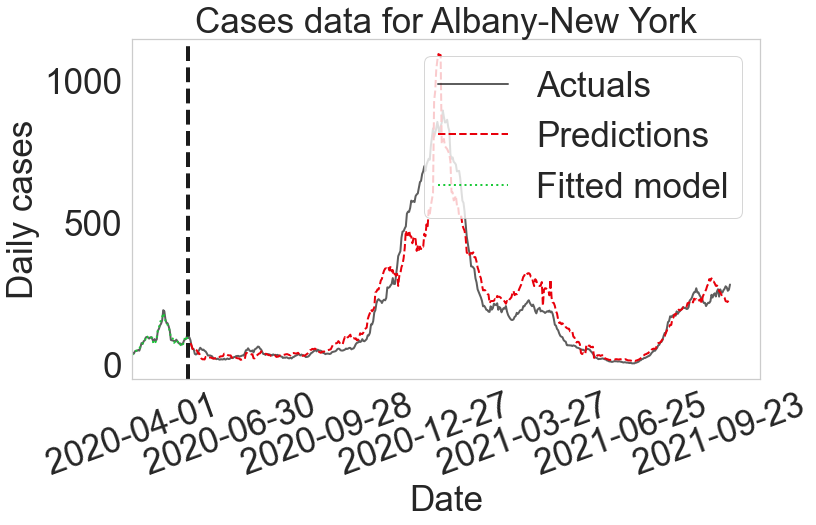

donors =  ['Atlantic-New Jersey', 'Barnstable-Massachusetts', 'Berkshire-Massachusetts', 'Bristol-Rhode Island', 'Cape May-New Jersey', 'Columbia-New York', 'Cumberland-Maine', 'Erie-New York', 'Franklin-Massachusetts', 'Fulton-New York', 'Genesee-New York', 'Gloucester-New Jersey', 'Greene-New York', 'Hampshire-Massachusetts', 'Hillsborough-New Hampshire', 'Hunterdon-New Jersey', 'Kent-Rhode Island', 'Litchfield-Connecticut', 'Madison-New York', 'Middlesex-Connecticut', 'New London-Connecticut', 'Niagara-New York', 'Onondaga-New York', 'Orleans-New York', 'Rockingham-New Hampshire', 'Schenectady-New York', 'Sussex-New Jersey', 'Tolland-Connecticut', 'Warren-New York', 'Washington-New York'] singvals: 9


In [104]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in ['Albany-New York']:
#otherStates = donors.copy()
    ''''''
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit_model(filter_donor = True, filter_method = 'quantile', singVals_estimate = True, singval_mathod ='auto')
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
     
    fig, axes = plt.subplots(1, 1, figsize = (12, 8))

    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    

    plt.show()

    print('donors = ',rscModel.donors, 'singvals:', rscModel.kSingularValues)
    

/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  wa

/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-package

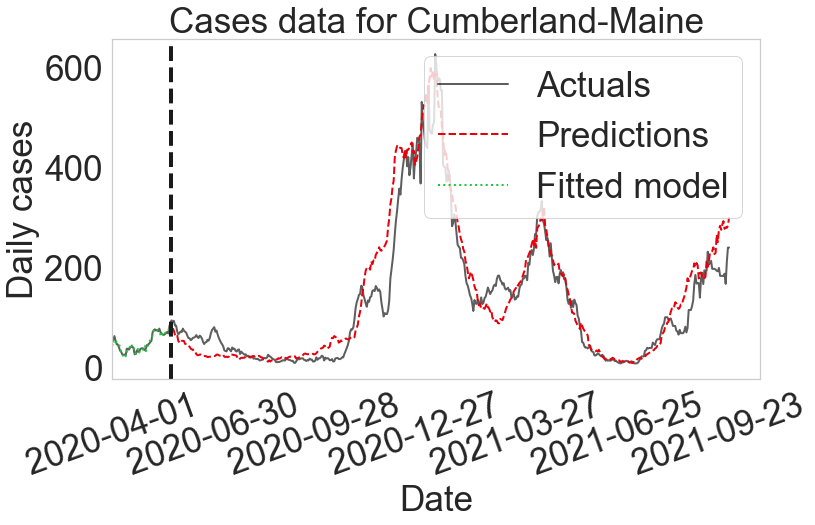

donors =  ['Androscoggin-Maine', 'Berkshire-Massachusetts', 'Bristol-Rhode Island', 'Chenango-New York', 'Chittenden-Vermont', 'Franklin-Massachusetts', 'Franklin-Vermont', 'Fulton-New York', 'Genesee-New York', 'Greene-New York', 'Hampshire-Massachusetts', 'Madison-New York', 'Merrimack-New Hampshire', 'Monroe-New York', 'New London-Connecticut', 'Newport-Rhode Island', 'Niagara-New York', 'Oneida-New York', 'Onondaga-New York', 'Orleans-New York', 'Rensselaer-New York', 'Rockingham-New Hampshire', 'Schenectady-New York', 'St. Lawrence-New York', 'Steuben-New York', 'Strafford-New Hampshire', 'Tioga-New York', 'Warren-New York', 'Washington-New York', 'Washington-Rhode Island', 'Windham-Vermont', 'Wyoming-New York'] singvals: 9


In [103]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in ['Cumberland-Maine']:
#otherStates = donors.copy()
    ''''''
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit_model(filter_donor = True, filter_method = 'quantile', singVals_estimate = True, singval_mathod ='auto')
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
     
    fig, axes = plt.subplots(1, 1, figsize = (12, 8))

    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    

    plt.show()

    print('donors = ',rscModel.donors, 'singvals:', rscModel.kSingularValues)
    

target: Albany-New York
number of donors before filtering: 145
2
number of donors after filtering: 127
target rank estimation:  2
Albany-New York donors: 145
Cases on 2020-05-24: 94


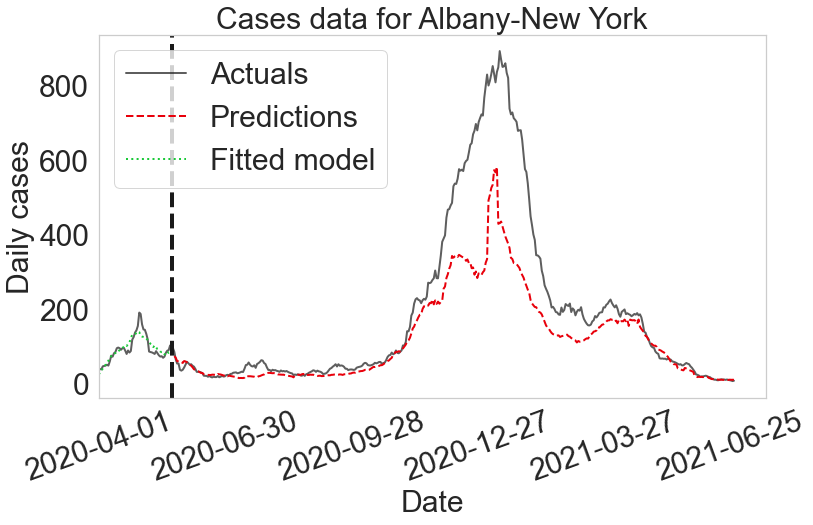

In [134]:

'''
import warnings
warnings.simplefilter('ignore')

FONTSIZE =  30
#lambdas = [1, 0.02]
test_days = 400
train_days = 53
singVals=4
tick_spacing = 90
aggregate1 = 0
aggregate2 = 0
weighted_avg1 = [0,0]
weighted_avg2 = [0,0]
low_thresh_date = '2020-05-24'
start_date = (dt.datetime.strptime(low_thresh_date,'%Y-%m-%d') - dt.timedelta(days = train_days)).strftime('%Y-%m-%d')
end_date = (dt.datetime.strptime(low_thresh_date,'%Y-%m-%d') + dt.timedelta(days = test_days)).strftime('%Y-%m-%d')
df = all_cases_data_pop.loc[start_date:]
df_pop = all_cases_data_pop_daily.loc[start_date:end_date]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days
high_thresh = low_thresh + test_days + 1# df_pop.shape[0]

donor_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]

donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in donor_states and names[0] != 'Unknown':
        donors.append(counties)

i = 0
#c = 50
for county_state in ['Albany-New York']:
    fig, axes = plt.subplots(1, 1, figsize = (12, 8))
    
    if county_state in donors:
        donors.remove(county_state)  
    
    
    if len(donors) == 0:
        continue

    

    
    rscModel = syn_model(county_state, singVals, [df_pop], high_thresh, low_thresh, otherStates=donors)
    
    # to ensure there aren't too few donors
    new_donors = rscModel.donors
    if len(new_donors) < 3:
        continue
        
    print('target:', county_state)
    #rscModel.fit_model(filter_donor = False)
    print('number of donors before filtering:', len(rscModel.donors))
    
    try:
        rscModel.fit_model(filter_donor = True, singVals_estimate = True)
        print('number of donors after filtering:', len(rscModel.donors))
        print('target rank estimation: ', rscModel.kSingularValues)
    except:
        rscModel.fit_model(filter_donor = True)
        print('target model rank estimation failed, rank 2 ued by default')

    
    print(county_state+" donors: "+str(len(new_donors))
                     + "\nCases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[county_state].iloc[low_thresh])))
    
    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    

    
    #plot_counterfactual_vs_prediction(donors, [county_state])

    

    predictions = rscModel.predictions 
    model_fit = rscModel.model_fit
    
    aggregate_fit_change = (df_pop[county_state][:low_thresh]-model_fit)
    aggregate_pred_change = (df_pop[county_state][low_thresh+1:high_thresh]-predictions )
    aggregate1 += aggregate_pred_change[-1]    
        
    county_pop = uscounties_population.loc[county_state].value
    weighted_avg1[0] += aggregate_pred_change[-1] * county_pop #* county_pop/1e6
    weighted_avg1[1] += county_pop
    plt.show()
    
 '''   
